Usando dispositivo: cpu
Epoch 0: Loss = 1.2421252727508545
Epoch 500: Loss = 0.016081128269433975
Epoch 1000: Loss = 0.009016122668981552
Epoch 1500: Loss = 0.006806051824241877
Epoch 2000: Loss = 0.004412026144564152
Epoch 2500: Loss = 0.01075480505824089
Epoch 3000: Loss = 0.0015571021940559149
Epoch 3500: Loss = 0.0013340492732822895
Epoch 4000: Loss = 0.0009285428677685559
Epoch 4500: Loss = 0.0010191831970587373


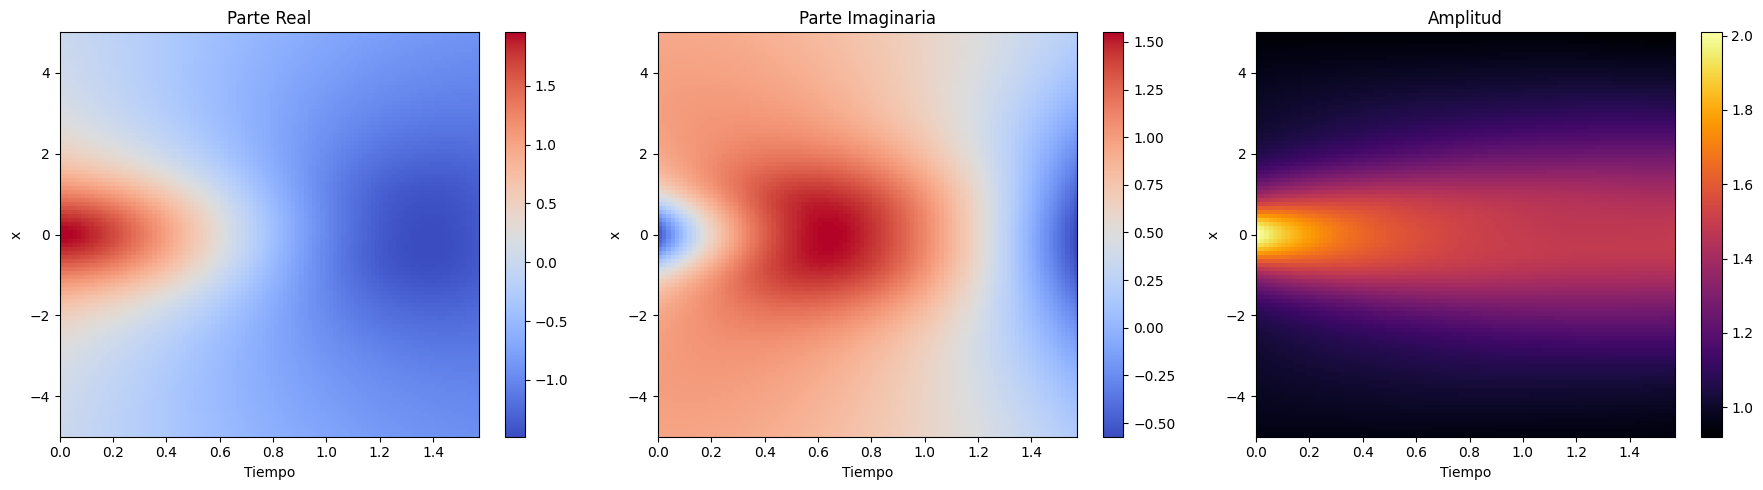

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Definir el dispositivo (usar GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Definir el dominio espacial y temporal
x_lower, x_upper = -5, 5   # Rango espacial
t_lower, t_upper = 0, np.pi / 2  # Rango temporal

# Número de puntos de muestreo (ajustado para mayor eficiencia)
Nx, Nt = 100, 100

# Crear malla de puntos en el dominio
t = torch.linspace(t_lower, t_upper, Nt, device=device, requires_grad=True)
x = torch.linspace(x_lower, x_upper, Nx, device=device, requires_grad=True)
X, T = torch.meshgrid(x, t, indexing='ij')
XT = torch.stack([X.flatten(), T.flatten()], dim=1).to(device)

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 2)  # Salida de dos componentes (real e imaginaria)
        )

    def forward(self, x):
        return self.net(x)

# Inicializar la red neuronal
model = PINN().to(device)

# Definir la función de pérdida basada en la ecuación diferencial
def loss_function(model, XT):
    u_v = model(XT)  # Salida de la red neuronal
    u, v = u_v[:, 0:1], u_v[:, 1:2]  # Separar en parte real e imaginaria

    # Calcular derivadas usando diferenciación automática
    u_t = torch.autograd.grad(u, XT, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    v_t = torch.autograd.grad(v, XT, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    u_xx = torch.autograd.grad(torch.autograd.grad(u, XT, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1], XT, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_xx = torch.autograd.grad(torch.autograd.grad(v, XT, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 0:1], XT, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 0:1]

    # Ecuación de Schrödinger no lineal
    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return torch.mean(f_u ** 2 + f_v ** 2)  # Minimizar el residuo de la ecuación diferencial

# Condiciones iniciales y de frontera
x_init = torch.linspace(x_lower, x_upper, Nx, device=device)
t_init = torch.full((Nx,), t_lower, device=device)
XT_init = torch.stack([x_init, t_init], dim=1).to(device)

h_init = 2 / torch.cosh(x_init).unsqueeze(1)  # Condición inicial h(0, x) = 2 sech(x)

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Entrenamiento simplificado
for epoch in range(5000):
    optimizer.zero_grad()
    loss_pde = loss_function(model, XT)  # Pérdida de la ecuación diferencial
    loss_ic = torch.mean((model(XT_init)[:, 0:1] - h_init) ** 2)  # Pérdida condición inicial
    loss = loss_pde + loss_ic  # Pérdida total
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Extraer la solución aprendida
with torch.no_grad():
    h_pred = model(XT).cpu().numpy()
    h_real_pred = h_pred[:, 0].reshape(Nx, Nt)
    h_imag_pred = h_pred[:, 1].reshape(Nx, Nt)
    h_amp_pred = np.sqrt(h_real_pred**2 + h_imag_pred**2)

# Visualización de la solución con mapas de colores
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

c1 = axs[0].imshow(h_real_pred, aspect='auto', extent=[t_lower, t_upper, x_lower, x_upper], origin='lower', cmap='coolwarm')
axs[0].set_title('Parte Real')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('x')
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].imshow(h_imag_pred, aspect='auto', extent=[t_lower, t_upper, x_lower, x_upper], origin='lower', cmap='coolwarm')
axs[1].set_title('Parte Imaginaria')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('x')
fig.colorbar(c2, ax=axs[1])

c3 = axs[2].imshow(h_amp_pred, aspect='auto', extent=[t_lower, t_upper, x_lower, x_upper], origin='lower', cmap='inferno')
axs[2].set_title('Amplitud')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('x')
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()
